In [ ]:
#######################
### Import Packages ###
#######################

# --- Base packages ---
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import geopandas as gpd

# --- Visualisation packages ---
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import altair as alt

# --- Mainly to supress Altair's warnings ---
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **RQ1**: _What is the trend of crime rates in Malaysia?_

---

## A. Import Data

In [2]:
# Import crime data.
crimePerPop_long = pd.read_csv("data/0_crimePerPop_long.csv")
crimePerPop_long['location'] = crimePerPop_long['state'].apply(lambda x: 'East Malaysia' if np.isin(x, ['Sabah', 'Sarawak', 'W.P. Labuan']) else 'West Malaysia')
crimePerPop_long = crimePerPop_long.set_index(['location', 'state', 'district'])

# Change from long to wide.
crimePerPop_wide = crimePerPop_long.reset_index()[['location', 'state', 'district']].drop_duplicates()
for y in crimePerPop_long.date.unique():
    df = crimePerPop_long[crimePerPop_long['date']==y].copy()
    df.columns = [x + "_" + str(y) for x in df.columns.values]
    crimePerPop_wide = crimePerPop_wide.merge(df, on=['location', 'state', 'district'])
crimePerPop_wide = crimePerPop_wide.set_index(['location', 'state', 'district'])


# Import geo data.
district_boundaries = gpd.read_file('data/district_boundaries.shp')

## B. Explore Aggregate Distributions

### B.1. Crime Rate Over Time

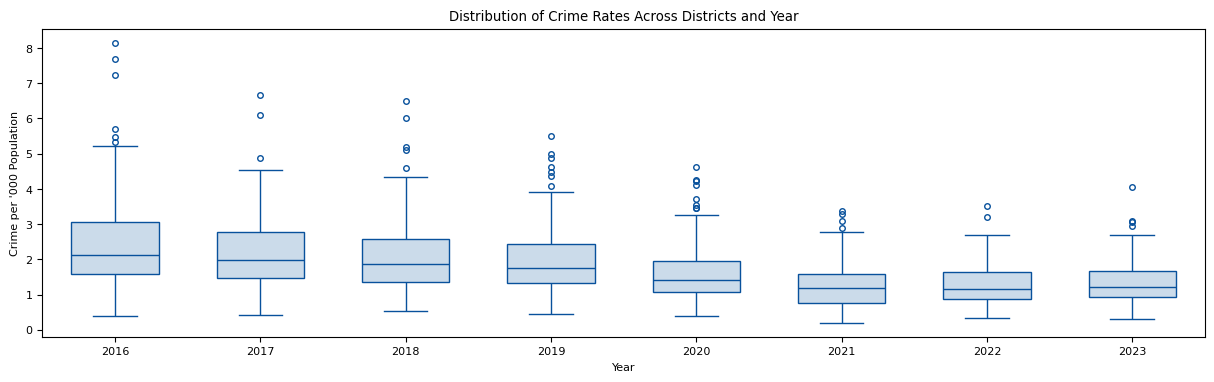

In [ ]:
fig1, axs1 = plt.subplots(1,1, figsize=(15, 4))

sns.boxplot(data=crimePerPop_long, x='date', y='crime_total', ax=axs1,
            width=0.6, fliersize=4, color='#c6dbef', linecolor='#08519c')
axs1.set_title("Distribution of Crime Rates Across Districts and Year")
axs1.set_xlabel("Year")
axs1.set_ylabel("Crime per '000 Population")

plt.show()

Observations:
- The distribution of crime rates has narrowed since 2016 suggesting that areas with higher crime rates in 2016 have seen a decrease in crime.
- Nonetheless, since 2021, there seems to be a few districts that saw higher crime rates, shown by the outlier point marks above the boxplots.

### B.2. Crime Rate by Type

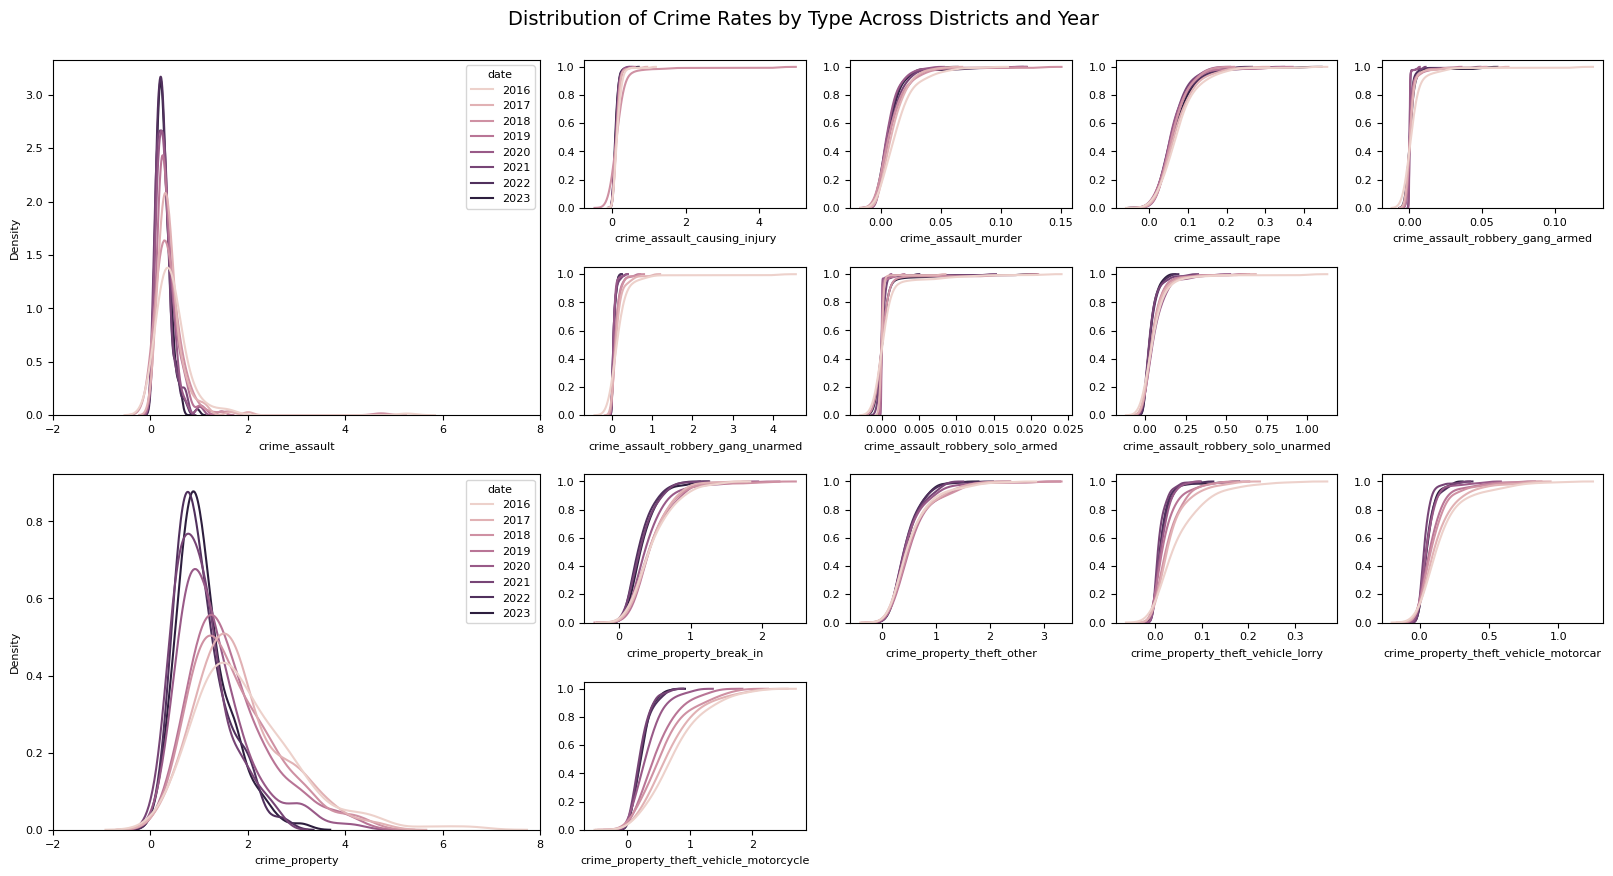

In [4]:
fig, axs = plt.subplots(4,6, figsize=(20,10))
fig.suptitle("Distribution of Crime Rates by Type Across Districts and Year", y=0.93, fontsize=14)

plt.subplots_adjust(hspace=0.4)
gs = axs[1, 2].get_gridspec()
for ax in axs[:, 0]:
    ax.remove()
for ax in axs[:, 1]:
    ax.remove()
axbig1 = fig.add_subplot(gs[:2, :2])
axbig2 = fig.add_subplot(gs[2:4, :2])

sns.kdeplot(data=crimePerPop_long, x='crime_assault', hue='date', common_norm=False, ax=axbig1)
axbig1.set_xlim([-2,8])
for i, col in enumerate(crimePerPop_long.columns[crimePerPop_long.columns.str.startswith("crime_assault_")]):
    sns.kdeplot(data=crimePerPop_long, x=col, hue='date', common_norm=False, ax=axs[i//4, 2 + i - (i//4)*4], cumulative=True)
    axs[i//4, 2 + i - (i//4)*4].legend_.remove()
    axs[i//4, 2 + i - (i//4)*4].set_ylabel("")
axs[1,5].axis('off')

sns.kdeplot(data=crimePerPop_long, x='crime_property', hue='date', common_norm=False, ax=axbig2)
axbig2.set_xlim([-2,8])
for i, col in enumerate(crimePerPop_long.columns[crimePerPop_long.columns.str.startswith("crime_property_")]):
    sns.kdeplot(data=crimePerPop_long, x=col, hue='date', common_norm=False, ax=axs[2 + i//4, 2 + i - (i//4)*4], cumulative=True)
    axs[2 + i//4, 2 + i - (i//4)*4].legend_.remove()
    axs[2 + i//4, 2 + i - (i//4)*4].set_ylabel("")
axs[3,3].axis('off')
axs[3,4].axis('off')
axs[3,5].axis('off')

plt.show()

Observations:
- Declining crime rates were mainly driven by declining property theft, particularly vehicle-related theft.

## C. Explore District-level Distributions

### C.1. Restructure Data to Facilitate Visual Analysis

In [5]:
# Define total crime columns.
TotalCrime_col = crimePerPop_wide.columns[crimePerPop_wide.columns.str.startswith("crime_total")]

# Calculate crime rate Quintiles
TotalCrimeQ = crimePerPop_wide.reset_index()[['location', 'state', 'district']].copy()
TotalCrimeQ = TotalCrimeQ.set_index(['location', 'state', 'district'])
for col in TotalCrime_col:
    TotalCrimeQ[col] = pd.qcut(crimePerPop_wide[col], q=5, labels=False)

# Calculate crime rate growth.
TotalCrimeG = crimePerPop_wide.reset_index()[['location', 'state', 'district']].copy()
TotalCrimeG = TotalCrimeG.set_index(['location', 'state', 'district'])
for i in range(1,8):
    TotalCrimeG[TotalCrime_col[i]] = (crimePerPop_wide[TotalCrime_col[i]] - crimePerPop_wide[TotalCrime_col[i-1]]).div(crimePerPop_wide[TotalCrime_col[i-1]])

sort_col_total = ['crime_total_2016', 'crime_total_2017', 'crime_total_2018', 'crime_total_2019', 'crime_total_2020', 'crime_total_2021', 'crime_total_2022', 'crime_total_2023']
sortedQ_total = TotalCrimeQ.reset_index().sort_values(['location'] + sort_col_total).set_index(['location', 'state', 'district'])
#sortedG_total = TotalCrimeG.reset_index(level=[0,1], drop=True).loc[sortedQ_total.index]
sortedG_total = TotalCrimeG.loc[crimePerPop_wide.reset_index().sort_values(['location', 'crime_total_2023']).set_index(['location', 'state', 'district']).index]





# Define total assault crime columns.
TotalAssaultCrime_col = crimePerPop_wide.columns[crimePerPop_wide.columns.str.startswith("crime_assault_2")]

# Calculate crime rate Quintiles
TotalAssaultCrimeQ = crimePerPop_wide.reset_index()[['location', 'state', 'district']].copy()
TotalAssaultCrimeQ = TotalAssaultCrimeQ.set_index(['location', 'state', 'district'])
for col in TotalAssaultCrime_col:
    TotalAssaultCrimeQ[col] = pd.qcut(crimePerPop_wide[col], q=5, labels=False)

# Calculate crime rate growth.
TotalAssaultCrimeG = crimePerPop_wide.reset_index()[['location', 'state', 'district']].copy()
TotalAssaultCrimeG = TotalAssaultCrimeG.set_index(['location', 'state', 'district'])
for i in range(1,8):
    TotalAssaultCrimeG[TotalAssaultCrime_col[i]] = (crimePerPop_wide[TotalAssaultCrime_col[i]] - crimePerPop_wide[TotalAssaultCrime_col[i-1]]).div(crimePerPop_wide[TotalAssaultCrime_col[i-1]])

sort_col_assault = ['crime_assault_2016', 'crime_assault_2017', 'crime_assault_2018', 'crime_assault_2019', 'crime_assault_2020', 'crime_assault_2021', 'crime_assault_2022', 'crime_assault_2023']
sortedQ_assault = TotalAssaultCrimeQ.reset_index().sort_values(['location'] + sort_col_assault).set_index(['location', 'state', 'district'])
#sortedG_assault = TotalAssaultCrimeG.reset_index(level=[0,1], drop=True).loc[sortedQ_assault.index]
sortedG_assault = TotalCrimeG.loc[crimePerPop_wide.reset_index().sort_values(['location', 'crime_assault_2023']).set_index(['location', 'state', 'district']).index]





# Define total crime columns.
TotalPropertyCrime_col = crimePerPop_wide.columns[crimePerPop_wide.columns.str.startswith("crime_property_2")]

# Calculate crime rate Quintiles
TotalPropertyCrimeQ = crimePerPop_wide.reset_index()[['location', 'state', 'district']].copy()
TotalPropertyCrimeQ = TotalPropertyCrimeQ.set_index(['location', 'state', 'district'])
for col in TotalPropertyCrime_col:
    TotalPropertyCrimeQ[col] = pd.qcut(crimePerPop_wide[col], q=5, labels=False)

# Calculate crime rate growth.
TotalPropertyCrimeG = crimePerPop_wide.reset_index()[['location', 'state', 'district']].copy()
TotalPropertyCrimeG = TotalPropertyCrimeG.set_index(['location', 'state', 'district'])
for i in range(1,8):
    TotalPropertyCrimeG[TotalPropertyCrime_col[i]] = (crimePerPop_wide[TotalPropertyCrime_col[i]] - crimePerPop_wide[TotalPropertyCrime_col[i-1]]).div(crimePerPop_wide[TotalPropertyCrime_col[i-1]])

sort_col_property = ['crime_property_2016', 'crime_property_2017', 'crime_property_2018', 'crime_property_2019', 'crime_property_2020', 'crime_property_2021', 'crime_property_2022', 'crime_property_2023']
sortedQ_property = TotalPropertyCrimeQ.reset_index().sort_values(['location'] + sort_col_property).set_index(['location', 'state', 'district'])
#sortedG_property = TotalPropertyCrimeG.reset_index(level=[0,1], drop=True).loc[sortedQ_property.index]
sortedG_property = TotalCrimeG.loc[crimePerPop_wide.reset_index().sort_values(['location', 'crime_property_2023']).set_index(['location', 'state', 'district']).index]


### C.2. Crime Rate Growth per District Across Time

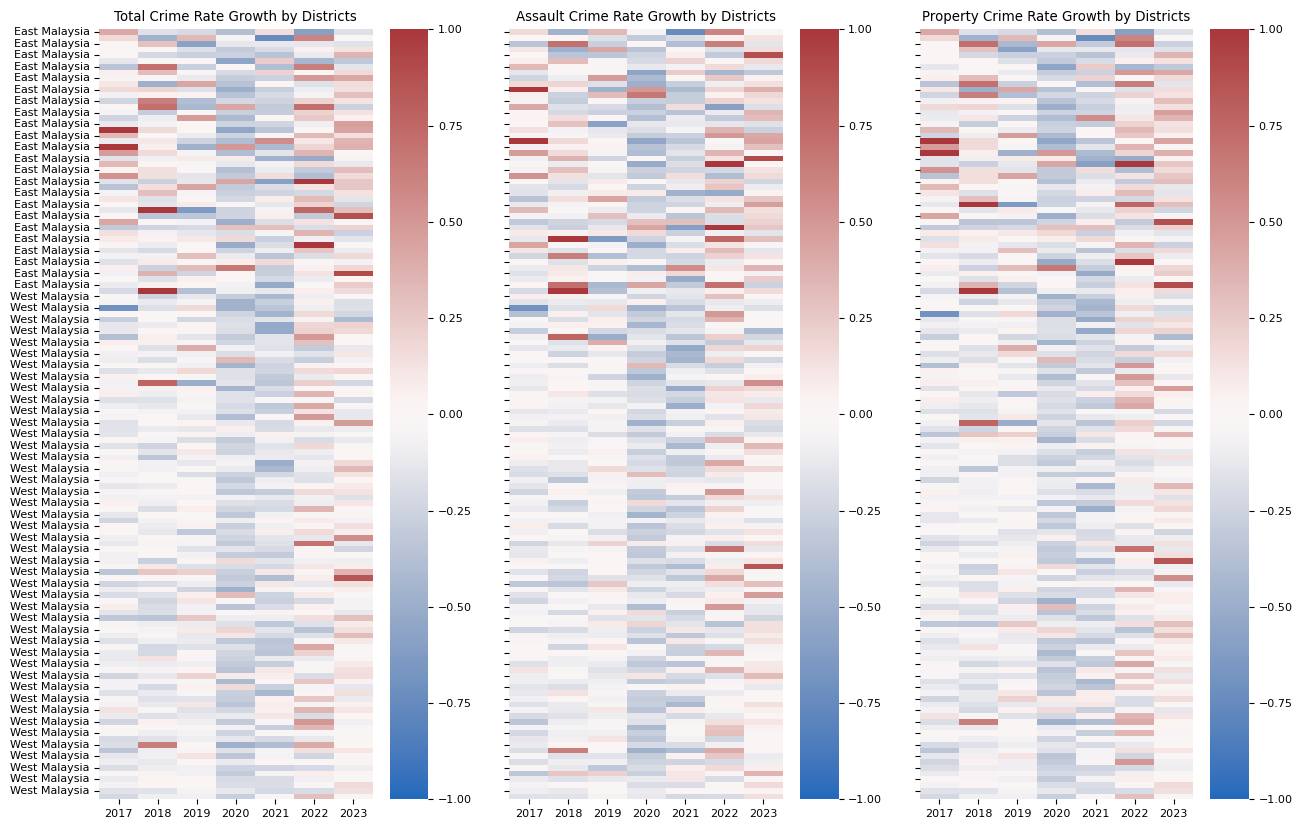

In [6]:
fig2, axs2 = plt.subplots(1,3,figsize=(15,10))

sns.heatmap(sortedG_total.reset_index(level=[1,2], drop=True), cmap='vlag', ax=axs2[0],
            center=0, vmin=-1, vmax=1,  
            xticklabels=[2017, 2018, 2019, 2020, 2021, 2022, 2023])
axs2[0].set_title("Total Crime Rate Growth by Districts")
axs2[0].set_ylabel("")

sns.heatmap(sortedG_assault, cmap='vlag', ax=axs2[1],
            center=0, vmin=-1, vmax=1,
            xticklabels=[2017, 2018, 2019, 2020, 2021, 2022, 2023])
axs2[1].set_title("Assault Crime Rate Growth by Districts")
axs2[1].set_ylabel("")
axs2[1].set_yticklabels([])

sns.heatmap(sortedG_property, cmap='vlag', ax=axs2[2],
            center=0, vmin=-1, vmax=1,
            xticklabels=[2017, 2018, 2019, 2020, 2021, 2022, 2023])
axs2[2].set_title("Property Crime Rate Growth by Districts")
axs2[2].set_ylabel("")
axs2[2].set_yticklabels([])

plt.show()

Chart Encodings: Each cell represents a district-year observation, and the hue encodes the annual crime rate growth. Positive growth rates are shown in shades of red while negative growth rates are shown in shades of blue.

Observations:
- Prior to 2020, districts in West Malaysia tend to experience a decline or negligible change in crime rates while districts in East Malaysia tend to have slightly positive crime rate growths.
- During the pandemic years of 2020 and 2021, all districts experienced a decline in crime rates.
- Post-2020, crime rates generally increase slightly.

### C.3. Quintiles of District Crime Rate for Each Year Across Time

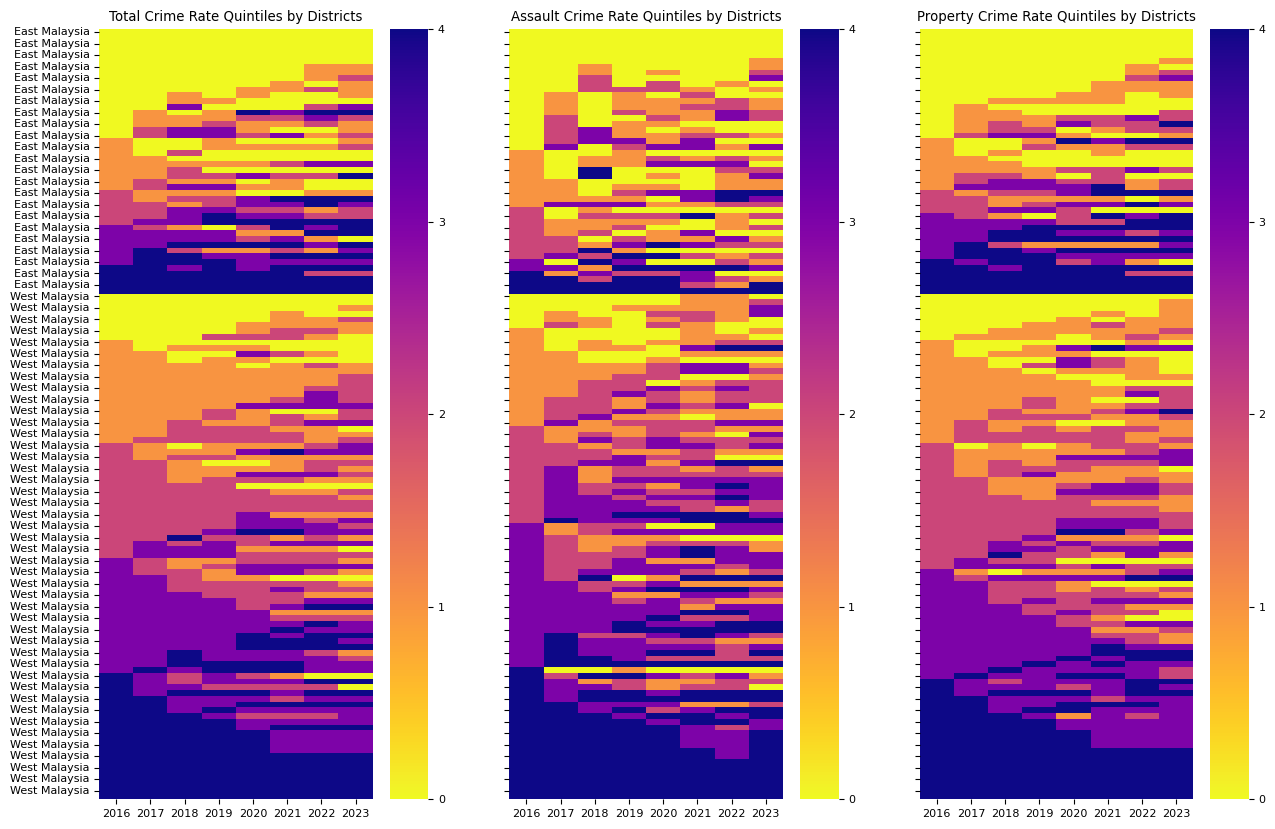

In [7]:
fig2, axs2 = plt.subplots(1,3,figsize=(15,10))

sns.heatmap(sortedQ_total.reset_index(level=[1,2], drop=True), cmap='plasma_r', ax=axs2[0], xticklabels=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
axs2[0].set_title("Total Crime Rate Quintiles by Districts")
axs2[0].set_ylabel("")
cbar = axs2[0].collections[0].colorbar
cbar.set_ticks(np.arange(0, 4, 1))
cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

sns.heatmap(sortedQ_assault, cmap='plasma_r', ax=axs2[1], xticklabels=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
axs2[1].set_title("Assault Crime Rate Quintiles by Districts")
axs2[1].set_ylabel("")
axs2[1].set_yticklabels([])
cbar = axs2[1].collections[0].colorbar
cbar.set_ticks(np.arange(0, 4, 1))
cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

sns.heatmap(sortedQ_property, cmap='plasma_r', ax=axs2[2], xticklabels=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
axs2[2].set_title("Property Crime Rate Quintiles by Districts")
axs2[2].set_ylabel("")
axs2[2].set_yticklabels([])
cbar = axs2[2].collections[0].colorbar
cbar.set_ticks(np.arange(0, 4, 1))
cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

Chart Encodings: The hue in this visual encodes the quintile that the district belongs to for the particular year. Darker shades are equivalent to higher quintiles and thus higher crime rates.

Observations:
- General ranking of districts based on crime rates remain the same.
- Notwithstanding, there are some movements between adjacent quintiles in recent years.

## D. Explore Geographical Distribution

In [8]:
# Merge with geographical data.
TotalCrimeQ_geo = pd.merge(district_boundaries, TotalCrimeQ, on='district')

cTotal16 = alt.Chart(TotalCrimeQ_geo).mark_geoshape(strokeWidth=1,stroke='lightgray',strokeOpacity=0.2
).encode(
    color=alt.Color('crime_total_2016:Q', scale=alt.Scale(scheme='plasma',domain=([0, 4]))),
    tooltip=['district:N','crime_total_2016:Q']
).properties(
    width=500,
    height=500
)

cTotal23 = alt.Chart(TotalCrimeQ_geo).mark_geoshape(strokeWidth=1,stroke='lightgray',strokeOpacity=0.2
).encode(
    color=alt.Color('crime_total_2023:Q', scale=alt.Scale(scheme='plasma',domain=([0, 4]), reverse=True)),
    tooltip=['district:N','crime_total_2023:Q']
).properties(
    width=500,
    height=500
)

alt.hconcat(cTotal16, cTotal23)

alt.HConcatChart(...)

Unable to make out any clear spatial trends.